## Construct Least Cost Paths - sorted on potential
This notebook constructs a pipeline network connecting all biogas sources using the following workflow: 
1.	Start with the biogas source with the largest potential (f^3/yr) and find its least cost path to the existing pipeline network.
2.	Move to the site with the next highest potential and find its least cost path to the updated pipeline (original + the pipeline linking the 1st site to the original pipe network). 
3.	Proceed with remaining sites, in order of declining potential, until all are connected.
4.	Then, when all sites have been connected, compute the accumulated volume of biogas passing through each segment from all “upstream sites”. 

#### The datasets required for this analysis include:
* The spreadsheet of biogas source, including coordinates, total waste, and biogas potential
* The MIT pipeline cost surface (all US)
* The REXTAG natural gas pipeline raster (all US)

#### Analysis consists of the following functions:
* **Data Prep**:
 * Import biogas locations as Pandas dataframe: `df_biogas`
 * Convert biogas locations to GeoPandas geodataframe, using WGS 84 coordinate ref. system (CRS): `gdf_biogas`
 * Import MIT pipeline cost surface as rasterio raster: `ds_pipecost_full`
 * Transform biogas geodataframe to same CRS as pipeline cost raster: `ds_pipelines_full`
 * Subset pipeline cost raster to extent of biogas locations, buffered by 5km: `ds_pipecost`
 * Subset pipeline raster to same extent as above: `ds_pipelines`

* **Functions**:
 * `cost_distance(source_pt, cost_array)`: Compute cost distance away from site. Outputs are a cost distance and traceback array. 
 * `compute_lcp(source_pt, cost_array, pipes_array)`: 

---
## Data Prep

In [1]:
#Imports
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point,LineString
import rasterio
import rasterio.mask

from skimage import graph

import matplotlib.pyplot as plt
%matplotlib inline

* Filenames

In [191]:
#Inputs
fn_biogas_excel = '..\\data\\NCSwineBiogasPotentialUniqueFarms.xlsx'
fn_MIT_cost_surface = '..\\data\\MIT_Surface_Full\\costsurface500m.img'
fn_REXTAG_pipe_raster = '..\\data\\processed\\USA_pipes_operational.tif'

#Outputs
fn_biogas_points = '..\\data\\processed\\biogas_sources.shp'
fn_subset_rasters =  '..\\data\\processed\\subset_data.tif'
fn_biogas_routes_geojson = '..\\data\\processed\\Routes.geojson'
fn_biogas_routes = ('..\\data\processed\\Routes.shp')

* Import biogas data and convert to geodataframe

In [3]:
#Read the excel sheet into a dataframe
df_biogas = pd.read_excel(fn_biogas_excel,sheet_name='Sheet2')

In [4]:
#Isolate records with biogas potential values and sort from highest to lowest
df_biogas = (
    #Remove records missing biogas potential data and the Total row
    df_biogas.loc[(df_biogas['Biogas Potential (m^3 / year)'] > 0) &
                  (df_biogas['Facility ID'] != 'TOTAL')]
    #Sort on biogas potential from highest to lowest
    .sort_values(by='Biogas Potential (m^3 / year)',ascending=False)
    #Reset the index
    .reset_index(drop=True))

In [5]:
#Display the contents
df_biogas.head()

,Facility ID,Facility Name,Address,City,County Name,Zip,Latitude,Longitude,Regulated Activity,Allowable Count,Total Waste (tons / year),Biogas Potential (m^3 / year)
0,291,Magnolia III DM Section 4 Sites 1-4 Section 3 ...,1114 Beasley Mill Rd,Warsaw,Duplin,28398.0,34.887500,-78.131400,Swine - Farrow to Wean,106640,490225.577124,1.372632e+07
1,154,Mr. Holmes Sites #1 - #14 #1 7 #18 Blueberry S...,2313 Mr Holmes Farm Rd,Garland,Bladen,28441.0,34.819191,-78.544711,Swine - Farrow to Wean,78630,301328.821333,8.437207e+06
2,1930,White Oaks Farm Inc,604 Benton Pond Rd,Fremont,Wayne,27830.0,35.516100,-77.923100,Swine - Farrow to Wean,65550,266616.481879,7.465261e+06
3,292,DM Farms Sec 2 Sites 1-4,419 Dail Rd,Magnolia,Duplin,28453.0,34.867200,-78.151400,Swine - Feeder to Finish,63360,243401.613396,6.815245e+06
4,1925,Somerset Farm,Sr 1139 1855-A N Line Rd,Roper,Washington,27970.0,35.888900,-76.535800,Swine - Feeder to Finish,59000,226652.386212,6.346267e+06


In [6]:
#Create a series of Point geometries for each record
geom = [Point(xy) for xy in zip(df_biogas.Longitude, df_biogas.Latitude)]
#Construct the geodataframe from the data and geometry, setting crs to WGS84
gdf_biogas = gpd.GeoDataFrame(df_biogas, geometry = geom, crs = 4326)
#Delete the original dataframe (to conserve memory)
del(df_biogas)

* Import the MIT cost and REXTAG pipelines rasters

In [7]:
#Read the MIT img file into a rasterio raster
ds_pipecost_full = rasterio.open(fn_MIT_cost_surface)
#Read the REXTAG tif file into a rasterio raster
ds_pipelines_full = rasterio.open(fn_REXTAG_pipe_raster)

* Transform the biogas points to the same crs as the MIT raster

In [8]:
#Get the MIT coordinate reference system
crs_pipecost = ds_pipecost_full.crs
#Apply the transformation
gdf_biogas = gdf_biogas.to_crs(crs_pipecost)
#Save to file
gdf_biogas.to_file(fn_biogas_points)

* Subset the cost and pipe rasters to the extent of the points + 5km

In [12]:
#Collapse the biogas points to a multipoint object, buffer 5000m, and pull its exent
bg_extent = gdf_biogas.geometry.unary_union.buffer(5000).envelope

#Mask the cost and pipe rasters
cost_image, cost_transform = rasterio.mask.mask(ds_pipecost_full,[bg_extent],crop=True)
pipe_image, pipe_transform = rasterio.mask.mask(ds_pipelines_full,[bg_extent],crop=True)

#Update the pipe raster dtype (uint8) to match the cost raster's (uint16)
pipe_image = pipe_image.astype(cost_image.dtype)

#Revise zero values to high cost values in cost_image
cost_image[cost_image == 0] = cost_image.max() * 10

* Save cost and pipeline subset images to two band raster dataset

In [192]:
#Extract the dimensions of the output rasters
out_height = cost_image.shape[1]
out_width = cost_image.shape[2]
#Create the subset cost surface metadata (altered from original)
out_meta = ds_pipecost_full.meta
out_meta.update({"driver":"GTiff",
                 "height":out_height,
                 "width":out_width,"count":2,
                 "transform":cost_transform})
#Stack the two images and write to output file
out_stacked = np.concatenate((cost_image,pipe_image),axis=0)
with rasterio.open(fn_subset_rasters,'w',**out_meta) as dst:
    dst.write(out_stacked)

In [193]:
#Read the raster back in 
ds_subset = rasterio.open(fn_subset_rasters)

---
## Analysis: Functions
1. Compute least cost path for a biogas source to nearest pipe

In [194]:
#Convert pipes array to a masked array
arr_pipes = ds_subset.read(2)
pipe_mask = np.ma.masked_array(arr_pipes,mask=arr_pipes==0)

#Create a graph from the cost raster
x_size,y_size = ds_subset.res
arr_cost = ds_subset.read(1)
lc_graph = graph.MCP_Geometric(arr_cost,sampling=(x_size,y_size))

#Make working copies of the biogas features and pipeline features
gdf_biogas_routes = gdf_biogas.copy(deep=True)
arr_pipes_working = arr_pipes.copy()

#Create lookup dictionary of pipe type
pipeDict = {1:'Transmission',2:'Distribution',3:'Gathering'}

#Iterate through each record
for layer_number,row in gdf_biogas_routes.iterrows():
    #Status: report every 20th run
    if layer_number%20 == 0: print(layer_number,end=' ')
   
    #Get the biogas feature for the specified layer number
    fac_id = row['Facility ID']
    bg_point = row['geometry']

    #Get the index location
    idx = ds_subset.index(bg_point.x,bg_point.y)
    
    #Compute the cost-distance and traceback arrays
    cd_array, tb_array = lc_graph.find_costs(starts=([idx]))

    ##Find the pipe coord with lowest cost in cd_array

    #Mask just pipeline pixels from cost distance output
    arr_cd_pipes = np.ma.masked_array(cd_array,mask=arr_pipes==0)
    
    #Locate the min value, i.e. where the LCP should end
    minPipeCost = arr_cd_pipes.min()
    
    #If minPipeCost is zero, something is up
    if minPipeCost == 0: 
        print(F"Error with {fac_id}")
        break

    #Determine the row and column where the min occurs
    rMin, cMin = np.where(arr_cd_pipes == minPipeCost)
    
    #Extract values from value arrays
    pipe_coords = (rMin[0],cMin[0])
    
    #Get the pipe type at the output
    pipe_type = pipeDict[arr_pipes[pipe_coords]]

    #Get the row/col indices of pixels in the LCP 
    lcp_indices = lc_graph.traceback(pipe_coords)
    
    #If the site is already on the pipeline, a lineString cannot be created
    if(len(lcp_indices)<2):
        continue

    ##Add the route polyline to the geodatabase
    #Create linestring from lcp_indices
    pipe_line = LineString([ds_subset.xy(r,c) for r,c in lcp_indices])
    
    #Update the dataset so that the geometry is the route
    gdf_biogas_routes.loc[layer_number,'geometry'] = pipe_line
    gdf_biogas_routes.loc[layer_number,'TYPE'] = pipe_type

    #Update the pipeline with the new connection
    for r,c in lcp_indices:
        arr_pipes[r,c] = 1

0 Error with 35


Some biogas locations are located too close to existing pipelines to have a LCP computed. These appear as points in the output `gdf_biogas_routes` geodataframe. To fix this, we find the nearest point along exisiting routes and connect these sources to those routes. 

---

In [214]:
FacID = 94
bg_point = gdf_biogas.loc[gdf_biogas['Facility ID'] == FacID,'geometry'].values[0]
#Get the index location
idx = ds_subset.index(bg_point.x,bg_point.y)

#Compute the cost-distance and traceback arrays
cd_array, tb_array = lc_graph.find_costs(starts=([idx]))

##Find the pipe coord with lowest cost in cd_array

#Mask just pipeline pixels from cost distance output
arr_cd_pipes = np.ma.masked_array(cd_array,mask=arr_pipes==0)

#Locate the min value, i.e. where the LCP should end
minPipeCost = arr_cd_pipes.min()

#Determine the row and column where the min occurs
rMin, cMin = np.where(arr_cd_pipes == minPipeCost)

#Extract values from value arrays
pipe_coords = (rMin[0],cMin[0])

#Get the pipe type at the output
pipe_type = pipeDict[arr_pipes[pipe_coords]]

#Get the row/col indices of pixels in the LCP 
lcp_indices = lc_graph.traceback(pipe_coords)


In [203]:
extent = (cMin[0]-20,cMin[0]+20,rMin[0]-20,rMin[0]+20)

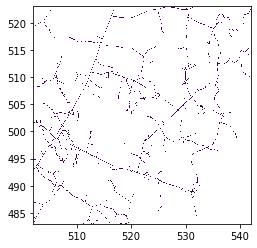

In [209]:
#plt.imshow(tb_array,extent=extent,cmap='Set1')
plt.imshow(arr_cd_pipes==0,extent=extent)

In [219]:
#Create the subset cost surface metadata (altered from original)
out_meta2 = ds_subset.meta

out_meta2.update({"nodata":19,"count":1,"dtype":rasterio.uint16})
#Stack the two images and write to output file
with rasterio.open('../scratch/pipes1.tif','w',**out_meta2) as dst:
    dst.write(arr_pipes,1)

In [176]:
out_meta2.update({"count":1,"dtype":rasterio.int16})
#Stack the two images and write to output file
with rasterio.open('../scratch/tbX.tif','w',**out_meta2) as dst:
    dst.write(tb_array,1)

---

In [97]:
#Reveal how many un-routed points
(gdf_biogas_routes.geom_type == 'Point').sum()

171

In [66]:
#Separate out line features from point features
gdfLines = gdf_biogas_routes.loc[gdf_biogas_routes.geometry.type == 'LineString']
gdfPoints = gdf_biogas_routes.loc[gdf_biogas_routes.geometry.type != 'LineString']

In [67]:
#For points, find nearest point on line
allLines = gdfLines.geometry.unary_union

In [68]:
from shapely.ops import nearest_points

In [77]:
gdf_routes = gdf_biogas_routes.copy(deep=True)

In [82]:
def addRoutes(shape):
    if shape.type=='LineString': 
        return shape
    else:
        return LineString(nearest_points(shape,allLines))

In [85]:
gdf_routes['geometry'] = gdf_routes['geometry'].apply(addRoutes)

In [87]:
#Rename columns
gdf_out = gdf_routes.rename({'Facility ID':'Fac_ID',
                                    'Total Waste (tons / year)':'Waste',
                                    'Biogas Potential (m^3 / year)':'Biogas'
                                   },axis=1)

#Filter for LineString records, and select columns: write to output
outColumns = ['Fac_ID','Waste','Biogas','TYPE','geometry']
gdf_out.loc[gdf_out.geometry.type=='LineString'][outColumns].to_file(fn_biogas_routes)

In [ ]:
#Write route attributes to csv file
gdf_biogas_routes.to_csv('..\\data\\processed\\RouteData.csv')

In [90]:
#Write points to file
outColumns = ['Fac_ID','Waste','Biogas','TYPE','geometry']
gdf_biogas_routes.loc[gdf_biogas_routes.geometry.type!='LineString'].to_file('../data/processed/Points.shp')